<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/main/tutorials/W1D2_ModelFitting/student/W1D2_Tutorial6.ipynb" target="_blank"><img alt="Open In Colab" src="https://colab.research.google.com/assets/colab-badge.svg"/></a>   <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/tutorials/W1D2_ModelFitting/student/W1D2_Tutorial6.ipynb" target="_blank"><img alt="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"/></a>

# Tutorial 6: Model Selection: Cross-validation

**Week 1, Day 2: Model Fitting**

**By Neuromatch Academy**

**Content creators**: Pierre-Étienne Fiquet, Anqi Wu, Alex Hyafil with help from Ella Batty

**Content reviewers**: Lina Teichmann, Patrick Mineault, Michael Waskom

**Production editors:** Spiros Chavlis

---
# Setup

##  Install and import feedback gadget


In [2]:
# @title Install and import feedback gadget

!pip3 install vibecheck datatops --quiet

from vibecheck import DatatopsContentReviewContainer
def content_review(notebook_section: str):
    return DatatopsContentReviewContainer(
        "",  # No text prompt
        notebook_section,
        {
            "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
            "name": "neuromatch_cn",
            "user_key": "y1x3mpx5",
        },
    ).render()


feedback_prefix = "W1D2_T6"

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.5 MB/s eta 0:00:00


In [3]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

##  Figure Settings


In [4]:
# @title Figure Settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

##  Plotting Functions


In [5]:
# @title Plotting Functions

def plot_cross_validate_MSE(mse_all):
  """ Plot the MSE values for the K_fold cross validation

  Args:
    mse_all (ndarray): an array of size (number of splits, max_order + 1)
  """
  plt.figure()
  plt.boxplot(mse_all, labels=np.arange(0, max_order + 1))

  plt.xlabel('Polynomial Order')
  plt.ylabel('Validation MSE')
  plt.title(f'Validation MSE over {n_splits} splits of the data')
  plt.show()


def plot_AIC(order_list, AIC_list):
  """ Plot the AIC value for fitted polynomials of various orders

  Args:
    order_list (list): list of fitted polynomial orders
    AIC_list (list): list of AIC values corresponding to each polynomial model on order_list
  """
  plt.bar(order_list, AIC_list)
  plt.ylabel('AIC')
  plt.xlabel('polynomial order')
  plt.title('comparing polynomial fits')
  plt.show()

##  Helper Functions


In [11]:
# @title Helper Functions

def ordinary_least_squares(x, y):
  """Ordinary least squares estimator for linear regression.

  Args:
    x (ndarray): design matrix of shape (n_samples, n_regressors)
    y (ndarray): vector of measurements of shape (n_samples)

  Returns:
    ndarray: estimated parameter values of shape (n_regressors)
  """

  return np.linalg.inv(x.T @ x) @ x.T @ y


def make_design_matrix(x, order):
  """Create the design matrix of inputs for use in polynomial regression

  Args:
    x (ndarray): input vector of shape (n_samples)
    order (scalar): polynomial regression order

  Returns:
    ndarray: design matrix for polynomial regression of shape (samples, order+1)
  """

  # Broadcast to shape (n x 1)
  if x.ndim == 1:
    x = x[:, None]

  #if x has more than one feature, we don't want multiple columns of ones so we assign
  # x^0 here
  design_matrix = np.ones((x.shape[0], 1))

  # Loop through rest of degrees and stack columns
  for degree in range(1, order + 1):
      design_matrix = np.hstack((design_matrix, x**degree))

  return design_matrix


def solve_poly_reg(x, y, max_order):
  """Fit a polynomial regression model for each order 0 through max_order.

  Args:
    x (ndarray): input vector of shape (n_samples)
    y (ndarray): vector of measurements of shape (n_samples)
    max_order (scalar): max order for polynomial fits

  Returns:
    dict: fitted weights for each polynomial model (dict key is order)
  """

  # Create a dictionary with polynomial order as keys, and np array of theta
  # (weights) as the values
  theta_hats = {}

  # Loop over polynomial orders from 0 through max_order
  for order in range(max_order + 1):

    X = make_design_matrix(x, order)
    this_theta = ordinary_least_squares(X, y)

    theta_hats[order] = this_theta

  return theta_hats


def evaluate_poly_reg(x, y, theta_hats, max_order):
    """ Evaluates MSE of polynomial regression models on data

    Args:
      x (ndarray): input vector of shape (n_samples)
      y (ndarray): vector of measurements of shape (n_samples)
      theta_hat (dict): fitted weights for each polynomial model (dict key is order)
      max_order (scalar): max order of polynomial fit

    Returns
      (ndarray): mean squared error for each order, shape (max_order)
    """

    mse = np.zeros((max_order + 1))
    for order in range(0, max_order + 1):
      X_design = make_design_matrix(x, order)
      y_hat = np.dot(X_design, theta_hats[order])
      residuals = y - y_hat
      mse[order] = np.mean(residuals ** 2)

    return mse

---
# Section 1: Cross-validation



##  Video 1: Cross-Validation


In [ ]:
# @title Video 1: Cross-Validation
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'OtKw0rSRxo4'), ('Bilibili', 'BV1mt4y1Q7C4')]
tab_contents = display_videos(video_ids, W=730, H=410)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

##  Submit your feedback


In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_CrossValidation_Video")

---
# Bonus

## Bonus Section 1: Akaike's Information Criterion (AIC)

In order to choose the best model for a given problem, we can ask how likely the data is under a given model. We want to choose a model that assigns high probability to the data. A commonly used method for model selection that uses this approach is **Akaike’s Information Criterion (AIC)**.

Essentially, AIC estimates how much information would be lost if the model predictions were used instead of the true data (the relative information value of the model). We compute the AIC for each model and choose the model with the lowest AIC. Note that AIC only tells us relative qualities, not absolute - we do not know from AIC how good our model is independent of others.

AIC strives for a good tradeoff between overfitting and underfitting by taking into account the complexity of the model and the information lost. AIC is calculated as:

\begin{equation}
\mathrm{AIC} = 2K - 2 \log(\mathcal{L})
\end{equation}

where $K$ is the number of parameters in your model and $\mathcal{L}$ is the likelihood that the model could have produced the output data.

Now we know what AIC is, we want to use it to pick between our polynomial regression models. We haven't been thinking in terms of likelihoods though - so how will we calculate $\mathcal{L}$?

As we saw in Tutorial 2, there is a link between mean squared error and the likelihood estimates for linear regression models that we can take advantage of.

*Derivation time!*

We start with our formula for AIC from above:

\begin{equation}
\mathrm{AIC} = 2k - 2 \log \mathcal{L}
\end{equation}

For a model with normal errors, we can use the log likelihood of the normal distribution:

\begin{equation}
\log \mathcal{L} = -\frac{n}{2} \log(2 \pi) -\frac{n}{2}\log(\sigma^2) - \sum_i^N \frac{1}{2 \sigma^2} (y_i - \tilde y_i)^2
\end{equation}

We can drop the first as it is a constant and we're only assessing relative information with AIC. The last term is actually also a constant: we don't know $\sigma^2$ in advance so we use the empirical estimate from the residual ($\hat{\sigma}^2 = 1/N\sum_i^N (y_i - \tilde y_i)^2$). Once we plug this in, the two $\sum [(y - \tilde y)^2]$ terms (in the numerator and denominator, respectively) cancel out and we are left with the last term as $\frac N 2$.

Once we drop the constant terms and incorporate into the AIC formula we get:

\begin{equation}
\mathrm{AIC} = 2k + n\log \left( \sigma^2 \right)
\end{equation}

We can replace $\sigma^2$ with the computation for variance (the sum of squared errors divided by number of samples). Thus, we end up with the following formula for AIC for linear and polynomial regression:

\begin{equation}
\mathrm{AIC} = 2K + n \log \left( \frac{\mathrm{SSE}}{n} \right)
\end{equation}

where $k$ is the number of parameters, $n$ is the number of samples, and $\mathrm{SSE}$ is the summed squared error.

### Bonus Exercise 1: Compute AIC

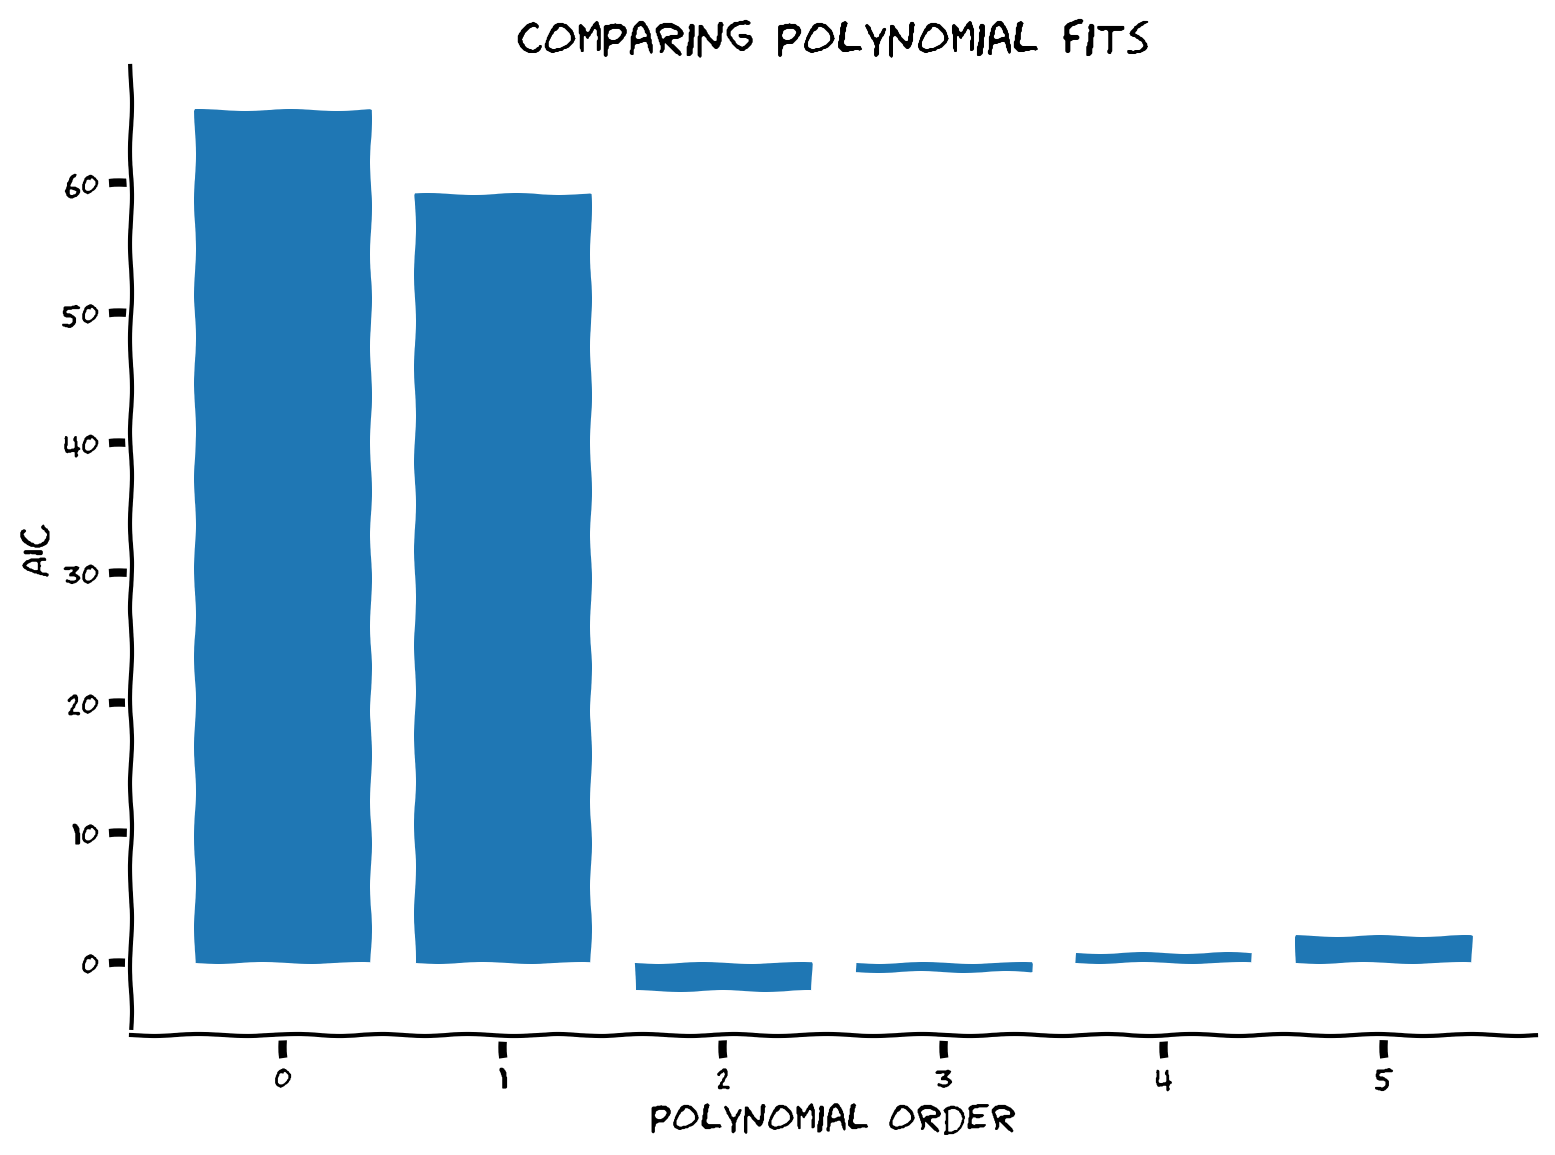

In [15]:
AIC_list = []
order_list = list(range(max_order + 1))

for order in order_list:

  # Compute predictions for this model
  X_design = make_design_matrix(x_train, order)
  y_hat = np.dot(X_design, theta_hats[order])

  # Compute SSE
  residuals = y_train - y_hat
  sse = np.sum(residuals ** 2)

  # Get K
  K = len(theta_hats[order])

  # Compute AIC
  AIC = 2 * K + n_train_samples * np.log(sse / n_train_samples)

  AIC_list.append(AIC)

# Visualize
with plt.xkcd():
  plt.bar(order_list, AIC_list)
  plt.ylabel('AIC')
  plt.xlabel('polynomial order')
  plt.title('comparing polynomial fits')
  plt.show()

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/main/tutorials/W1D2_ModelFitting/solutions/W1D2_Tutorial6_Solution_16748857.py)

*Example output:*

<img alt='Solution hint' align='left' width=777.0 height=577.0 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/tutorials/W1D2_ModelFitting/static/W1D2_Tutorial6_Solution_16748857_0.png>



##Which model would we choose based on AIC?

Based on the provided plot comparing the AIC values for polynomial fits of different orders, we would choose the model with the lowest AIC value. In the plot, the polynomial orders range from 0 to 5.

From the graph:

Polynomial orders 0 and 1 have very high AIC values.
Polynomial orders 2 through 5 have much lower AIC values.
Among polynomial orders 2 through 5, the differences in AIC values appear to be very small.
Since the AIC value is lowest for polynomial orders 2 through 5 and they are almost indistinguishable in the plot, any of these orders could be considered optimal based on AIC. However, without additional numerical details, we might tentatively choose the simplest model with the lowest polynomial order among these, which is the polynomial of order 2, as it is generally preferable to choose the simpler model when performance is similar.

Thus, based on AIC, we would choose the polynomial model of order 2.

####  Submit your feedback


In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Compute_AIC_Bonus_Exercise")